In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['dark_background'])
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set global plot parameters. 
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 80

In [64]:
class Body():

    def __init__(self, x0, y0, box_size=100, inf_dist=1, sigma=0.01, recov_rate=0.75):
        self.box_size = box_size
        self.x = x0
        self.y = y0
        self.sigma = sigma
        self.recov_rate = recov_rate
        self.recov_rate
        self.loc_history = [(x0, y0)]
        self.is_S = True
        self.is_I = False
        self.is_R = False
        self.S_history = [True]
        self.I_history = [False]
        self.R_history = [False]
        self.inf_dist = inf_dist

    def add_to_loc_history(self, x, y):
        self.loc_history.append((x, y))
    
    def add_to_S_history(self, x):
        self.S_history.append(x)
        
    def add_to_I_history(self, x):
        self.I_history.append(x)
        
    def add_to_R_history(self, x):
        self.R_history.append(x)
        
    @staticmethod
    def new_position(z, dz, box_size):
        zhat = abs(z + dz)

        if(zhat > box_size):
            zhat = 2*box_size - zhat
        return zhat

    def move(self):
        sigma = self.sigma * self.box_size
        dx = np.random.normal(loc=0.0, scale=sigma)
        dy = np.random.normal(loc=0.0, scale=sigma)
        self.x = Body.new_position(z=self.x, dz=dx, box_size=self.box_size)
        self.y = Body.new_position(z=self.y, dz=dy, box_size=self.box_size)
        self.add_to_loc_history(self.x, self.y)

    def distance(self, other): 
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)

    def recover(self):
        if (self.is_I):
            prob = np.exp(-1/self.recov_rate)
            change_status = np.random.binomial(n=1, p=prob)
            if (change_status):
                self.is_S = False
                self.is_I = False
                self.is_R = True
    
    def infect(self, other):
        dist = self.distance(other)
        status = self.is_I + other.is_I
        
        if ((self.is_I) & (other.is_S)):
                prob = np.exp(-dist/self.inf_dist)
                change_status = np.random.binomial(n=1, p=prob)
                if (change_status):
                    other.is_S = False
                    other.is_I = True
                    other.is_R = False
                    
        elif ((self.is_S) & (other.is_I)):
                prob = np.exp(-dist/other.inf_dist)
                change_status = np.random.binomial(n=1, p=prob)
                if (change_status):
                    self.is_S = False
                    self.is_I = True
                    other.is_R = False

In [65]:
class Simulation():

    def __init__(self, n_bodies, init_I=1, box_size=100, inf_dist=2):
        self.n_bodies = n_bodies
        self.init_I = init_I
        self.box_size = box_size
        # initialize first timestep
        ## Center
        self.bodies = [
            Body(
                x0=np.random.uniform(low=0.0, high=self.box_size),
                y0=np.random.uniform(low=0.0, high=self.box_size),
                box_size=self.box_size,
                inf_dist=inf_dist/self.n_bodies
            )
            for i in range(0, n_bodies-init_I)
        ]
        # place initN infected in center
        for i in range(init_I):
            self.bodies.append(
                    Body(
                        x0=np.random.uniform(low=0.45*self.box_size, high=0.55*self.box_size),
                        y0=np.random.uniform(low=0.45*self.box_size, high=0.55*self.box_size),
                        box_size=self.box_size,
                        inf_dist=inf_dist/self.n_bodies
                    )
            )
            self.bodies[-1].is_S = False
            self.bodies[-1].is_I = True
            self.bodies[-1].is_R = False
            self.bodies[-1].I_history = [True]

    def run(self, n_iter, t_intervention=None, strength_intervention=0.25):
        self.n_iter = n_iter
        self.t_intervention = t_intervention
        
        for i in range(n_iter-1):
            
            # TDPF
            if t_intervention:
                if i == t_intervention:
                    for b in self.bodies:
                        b.sigma *= strength_intervention
                        b.inf_dist *= 2*strength_intervention
            
            # recover
            for j, b1 in enumerate(self.bodies):
                b1.recover()     
            # infect
            for j, b1 in enumerate(self.bodies):
                for k, b2 in enumerate(self.bodies):
                    if (j < k):
                        b1.infect(b2)
            # update health status
            [b.add_to_S_history(b.is_S) for b in self.bodies]
            [b.add_to_I_history(b.is_I) for b in self.bodies]
            [b.add_to_R_history(b.is_R) for b in self.bodies]
            # move
            [b.move() for b in self.bodies]
        print('done simulating')
        
    def animate(self):
        fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8, 4))
        # bodies
        ax=axes[0]
        ax.set(title='', xlim=(0, self.box_size), ylim=(0, self.box_size))
        ax.set_xticks([])
        ax.set_yticks([])
        scat = ax.scatter(x=[], y=[], c='black', s=12, marker='o')
        
        # SIR plot
        axes[1].set_xlim([0, self.n_iter])
        axes[1].set_ylim([0, 100])
        axes[1].set_xlabel('Time', fontsize=14)
        axes[1].set_ylabel('Fraction of population (%)', fontsize=14)
        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)

        time = []
        S_lst = []
        I_lst = []
        R_lst = []
        line_S, = axes[1].plot([], [], color=sns_c[2], linewidth=4)
        line_I, = axes[1].plot([], [], color=sns_c[3], linewidth=4)
        line_R, = axes[1].plot([], [], color=sns_c[7], linewidth=4)
        axes[1].legend(['S', 'I', 'R'], fontsize=14, loc=1)
        fig.tight_layout()
        
        if self.t_intervention:
            axes[1].axvline(x=t_intervention, ymin=0, ymax=1, color='white', linewidth=2, linestyle='--')

        def update(i):
            
            # scatterplot
            x = [b.loc_history[i][0] for b in self.bodies]
            y = [b.loc_history[i][1] for b in self.bodies]
            x = np.array(x).reshape(-1, 1)
            y = np.array(y).reshape(-1, 1)
            scat.set_offsets(np.concatenate((x, y), axis=1))
            # determine right color
            colors=[]
            for b in self.bodies:
                if b.I_history[i]: 
                    colors.append(sns_c[3])
                elif b.R_history[i]:
                    colors.append(sns_c[7])
                else:
                    colors.append(sns_c[2])
            scat.set_edgecolors(np.array(colors))
            scat.set_facecolors(np.array(colors))
            
            # disease progression plot
            S = sum([b.S_history[i] for b in self.bodies])
            I = sum([b.I_history[i] for b in self.bodies])
            R = sum([b.R_history[i] for b in self.bodies])

            time.append(i)
            S_lst.append(S/self.n_bodies*100)
            I_lst.append(I/self.n_bodies*100)
            R_lst.append(R/self.n_bodies*100)
            
            line_S.set_data(time[:i],S_lst[:i])
            line_I.set_data(time[:i],I_lst[:i])
            line_R.set_data(time[:i],R_lst[:i])
                
            return scat, line_S, line_I, line_R

        anim = FuncAnimation(fig, update, frames=n_iter, interval=100, blit=True)
        return anim

done simulating


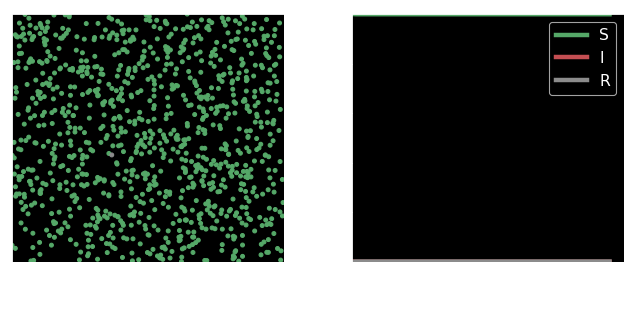

In [74]:
L = 200 # box size
n_bodies = 1000 # individuals
n_iter = 75 # timesteps
t_intervention = None
strength_intervention = 0.35

sim = Simulation(n_bodies=n_bodies, box_size=L, init_I=1, inf_dist=3100)
sim.run(n_iter=n_iter, t_intervention=t_intervention, strength_intervention=strength_intervention)

anim = sim.animate() 
HTML(anim.to_jshtml())
anim.save('animation.gif', writer='imagemagick', fps=8)